# Линейный автоэнкодер для одного параметра

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
plt.style.use('seaborn')

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
from skimage import transform
from sklearn.metrics import roc_auc_score, f1_score
from functions import *
from functions import good_cols, SignalDataset_1param, Linear_Autoencoder
from sklearn.model_selection import train_test_split
%matplotlib inline

**Параметры**

In [3]:
good_cols

['activityID',
 'heart rate',
 'temperature hand',
 '3Da_x scale_16 hand',
 '3Da_y scale_16 hand',
 '3Da_z scale_16 hand',
 '3Dg_x hand',
 '3Dg_y hand',
 '3Dg_z hand',
 '3Dm_x hand',
 '3Dm_y hand',
 '3Dm_z hand',
 'temperature chest',
 '3Da_x scale_16 chest',
 '3Da_y scale_16 chest',
 '3Da_z scale_16 chest',
 '3Dg_x chest',
 '3Dg_y chest',
 '3Dg_z chest',
 '3Dm_x chest',
 '3Dm_y chest',
 '3Dm_z chest',
 'temperature ankle',
 '3Da_x scale_16 ankle',
 '3Da_y scale_16 ankle',
 '3Da_z scale_16 ankle',
 '3Dg_x ankle',
 '3Dg_y ankle',
 '3Dg_z ankle',
 '3Dm_x ankle',
 '3Dm_y ankle',
 '3Dm_z ankle']

*смена рандома*

In [83]:
a = np.random.randint(1000)
np.random.seed(a)
a

270

**Выбор параметра и длины сигнала**

In [85]:
SIG_LEN = 200
PARAM = np.random.choice(good_cols[1:])
# PARAM =  'heart rate' # Если хотим конретный параметр
PARAM

'3Dm_x hand'

**Загрузка сигналов**

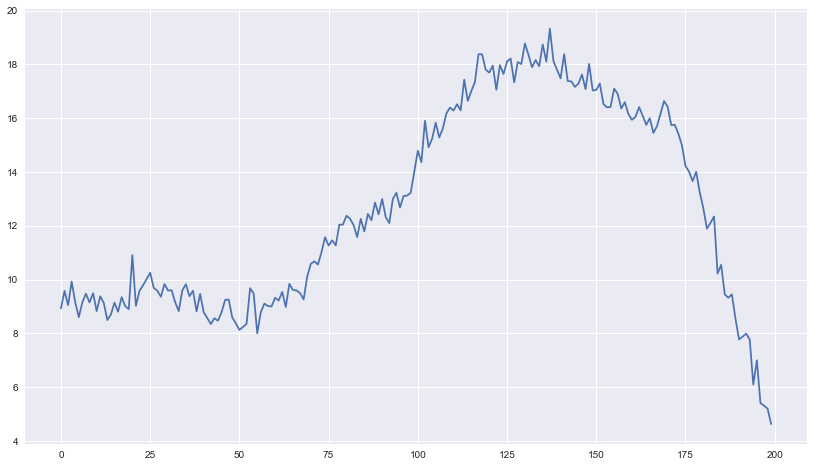

In [86]:
signals = load_signals_1param(SIG_LEN, PARAM)
print_signal(signals[0])

**Разбиение сигналов на группы**

In [87]:
NUMBER_OF_GROUPS = 10

signal_groups = get_signal_groups(signals, NUMBER_OF_GROUPS, N=2000)

**Выбор группы, с которой будем работать**

In [88]:
NUMBER_OF_GROUP = np.random.randint(NUMBER_OF_GROUPS)
group = signal_groups[NUMBER_OF_GROUP]
NUMBER_OF_GROUP

7

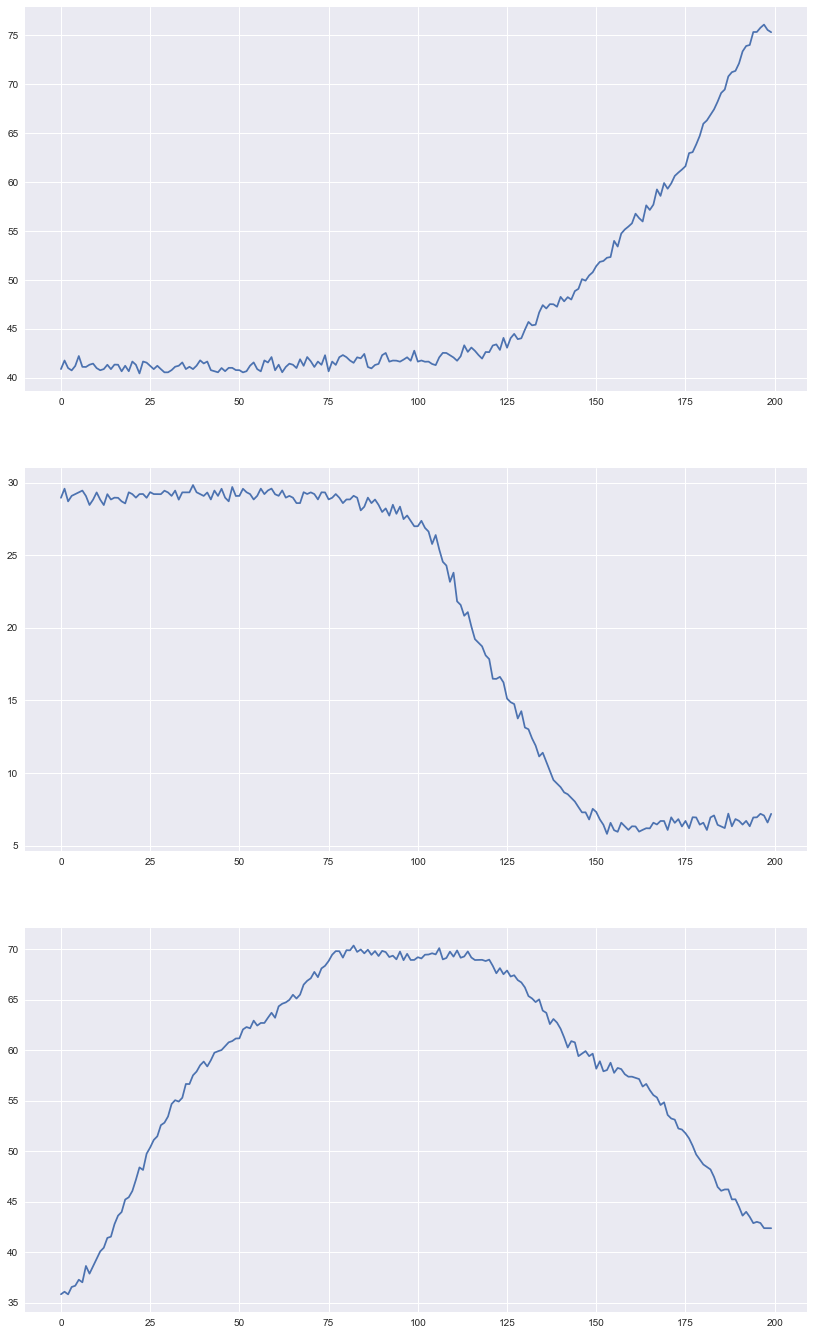

In [89]:
print_signal(signal_groups[NUMBER_OF_GROUP][:3])

**Подготовка данных**

In [90]:
X_norm = np.array(group, dtype=np.float64)
x_mean = np.mean(X_norm, axis=(0,1))
x_var = np.var(X_norm, axis=(0,1))
X_norm -= x_mean
if x_var:
    X_norm /= x_var
else:
    X_norm *= 0

X_train_tensor, X_val_tensor = train_test_split(torch.FloatTensor(X_norm), random_state=42, test_size = 0.2)
X_train_tensor.shape, X_val_tensor.shape

(torch.Size([285, 200]), torch.Size([72, 200]))

In [91]:
torch.min(X_train_tensor), torch.max(X_train_tensor), x_mean, x_var

(tensor(-0.1598), tensor(0.1460), 27.718856144349445, 522.136831798307)

In [92]:
BATCH_SIZE = 64

trainset = SignalDataset_1param(X_train_tensor)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)

testset = SignalDataset_1param(X_val_tensor)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)
len(trainset)

285

**Подготовка модели**

In [93]:
params_per_layer = [SIG_LEN, 2048, 1024, 128, 8]
net = Linear_Autoencoder(params_per_layer, activation=nn.LeakyReLU)

**Обучение**

In [94]:
def train(model, num_epochs, loss_func, learning_rate, trainset, trainloader, valset):
    losses = []
    val_losses = []

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    ebar = tqdm(range(num_epochs))

    for epoch_num in ebar:
        running_loss = 0.0
        iter_num = 0
        pbar = enumerate(trainloader)
        for iter_num, X_batch in pbar:
            iter_num +=1

            recon = model(X_batch)

            loss = loss_func(recon, X_batch)
            running_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        line = '[{}/{}] current loss: {}'.format(epoch_num+1, num_epochs, running_loss/len(trainset))
        ebar.set_description(line)

        losses.append(running_loss/len(trainset))

        with torch.no_grad():
            recon = model(valset)
            score = loss_func(recon, valset).item()
            val_losses.append(score)
        
    return losses, val_losses

In [95]:
NUM_EPOCHS = 100
learning_rate = 3e-4
loss_fn = torch.nn.MSELoss()

losses, val_losses = train(net, NUM_EPOCHS, loss_fn, learning_rate, trainset, trainloader, X_val_tensor)

[100/100] current loss: 4.950337091015586e-07: 100%|█████████████████████████████████| 100/100 [00:26<00:00,  3.79it/s]


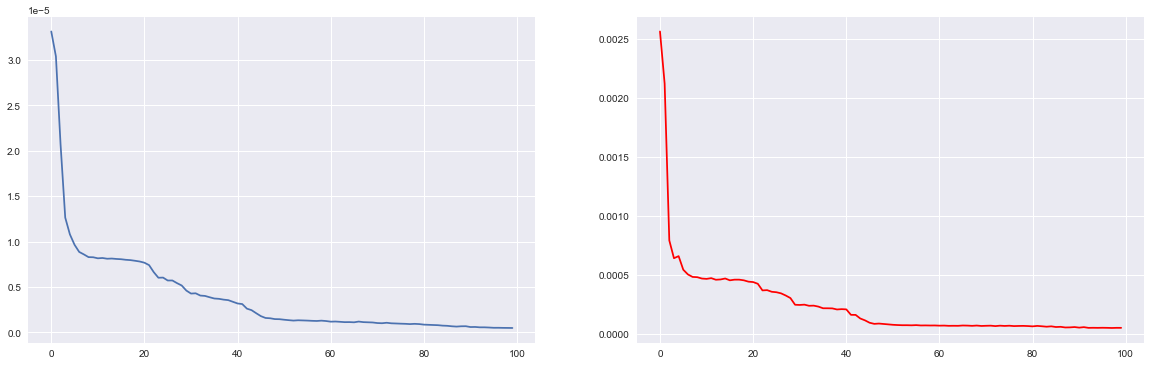

In [96]:
fig, axs = plt.subplots(1,2,figsize=(20,6))
axs[0].plot(np.arange(NUM_EPOCHS), losses)
axs[1].plot(np.arange(NUM_EPOCHS), val_losses, color='red')
plt.show()

## И что же получилось

### Базовые тесты

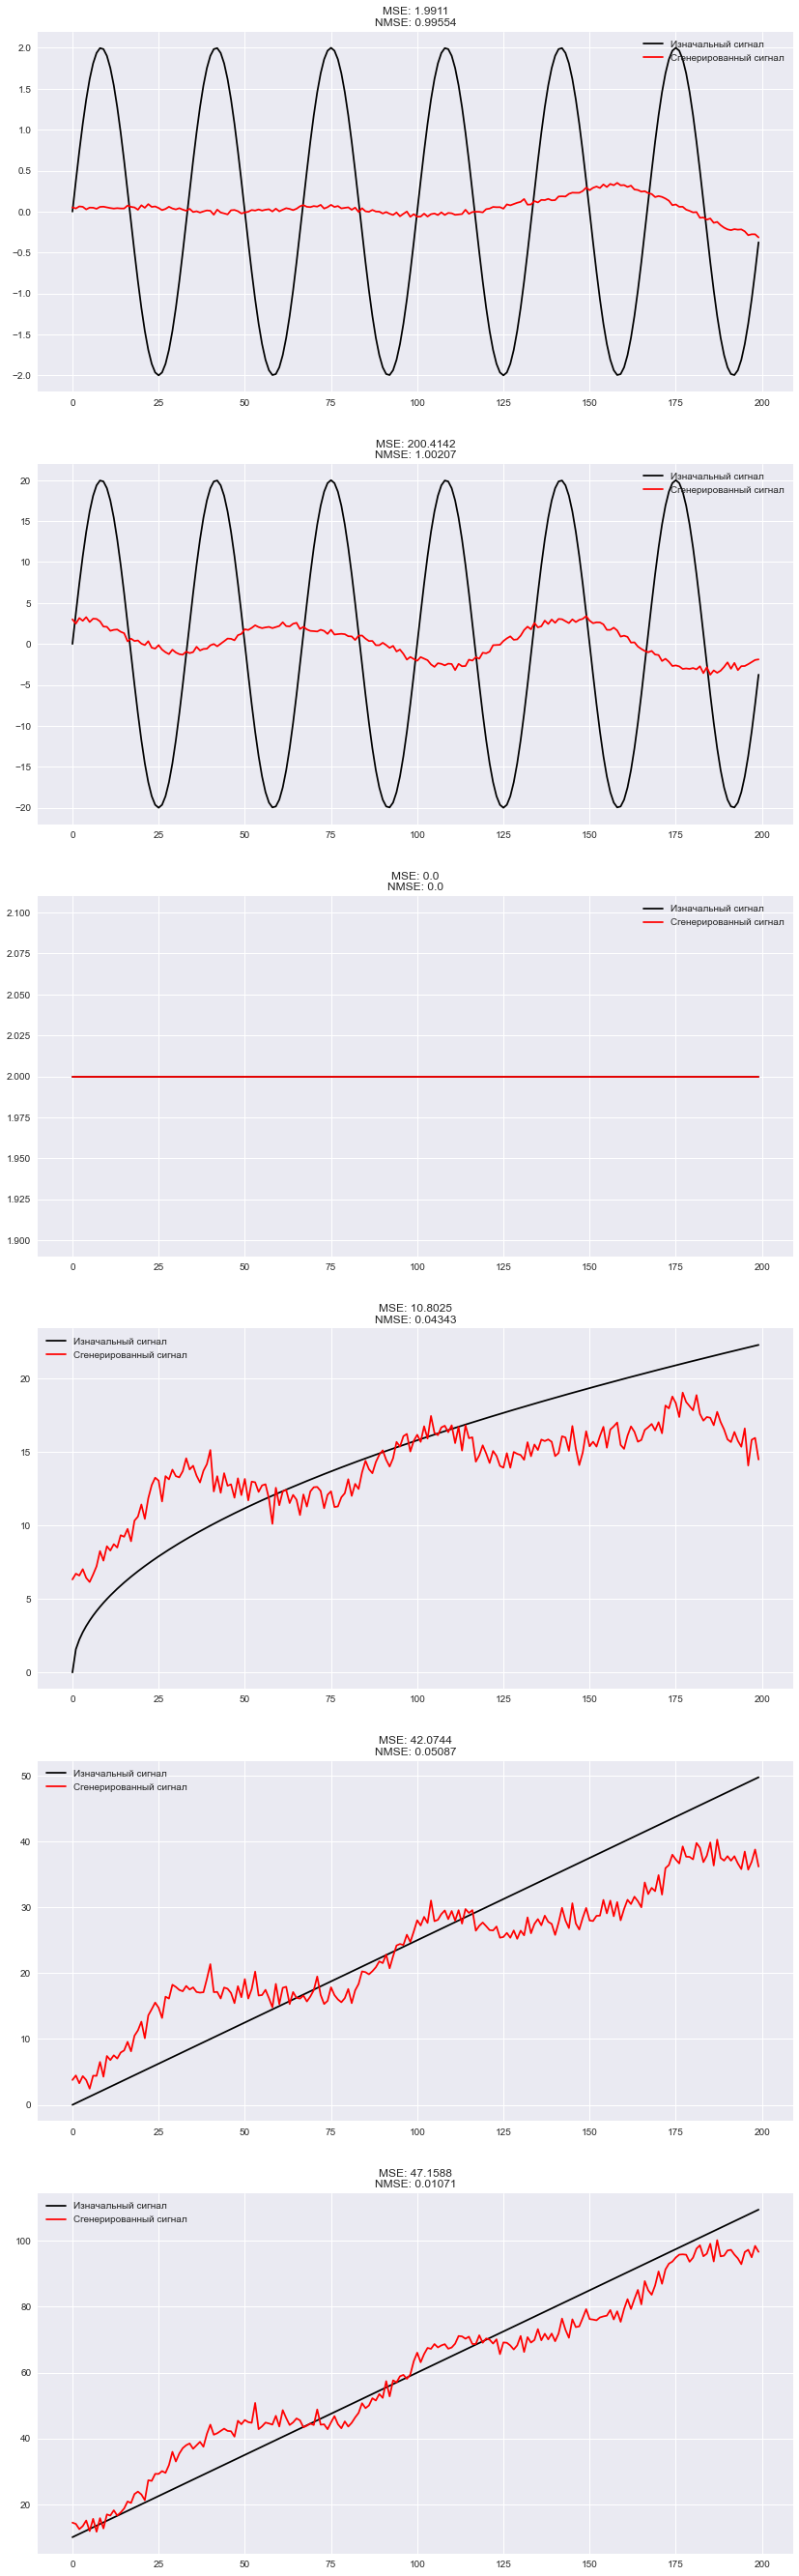

In [97]:
basic_func_check(net, SIG_LEN)

### Тесты на обучающей выборке

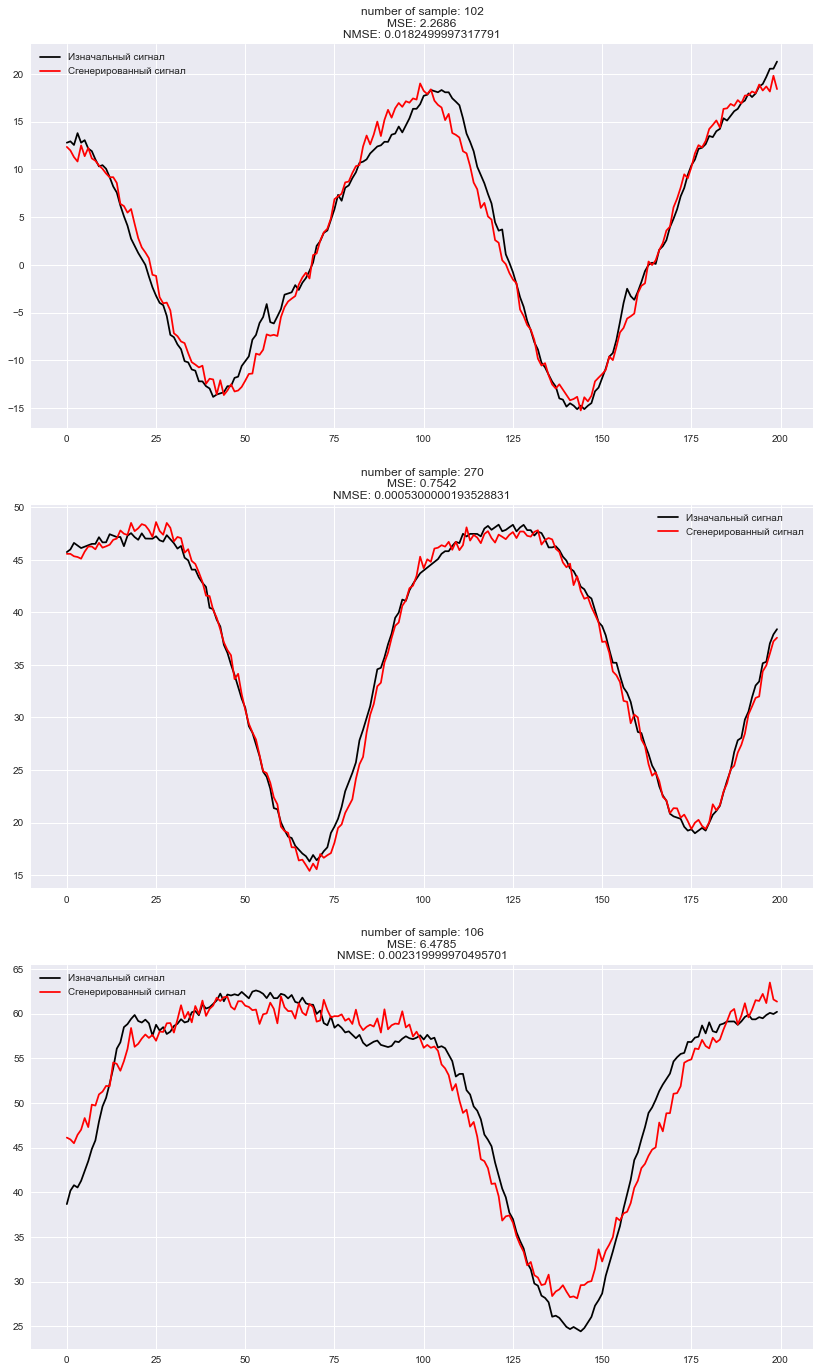

In [98]:
N = 3
tensor_check(net, X_train_tensor, N, x_mean, x_var, without_unnorm=False)

### Тесты на валидационной выборке

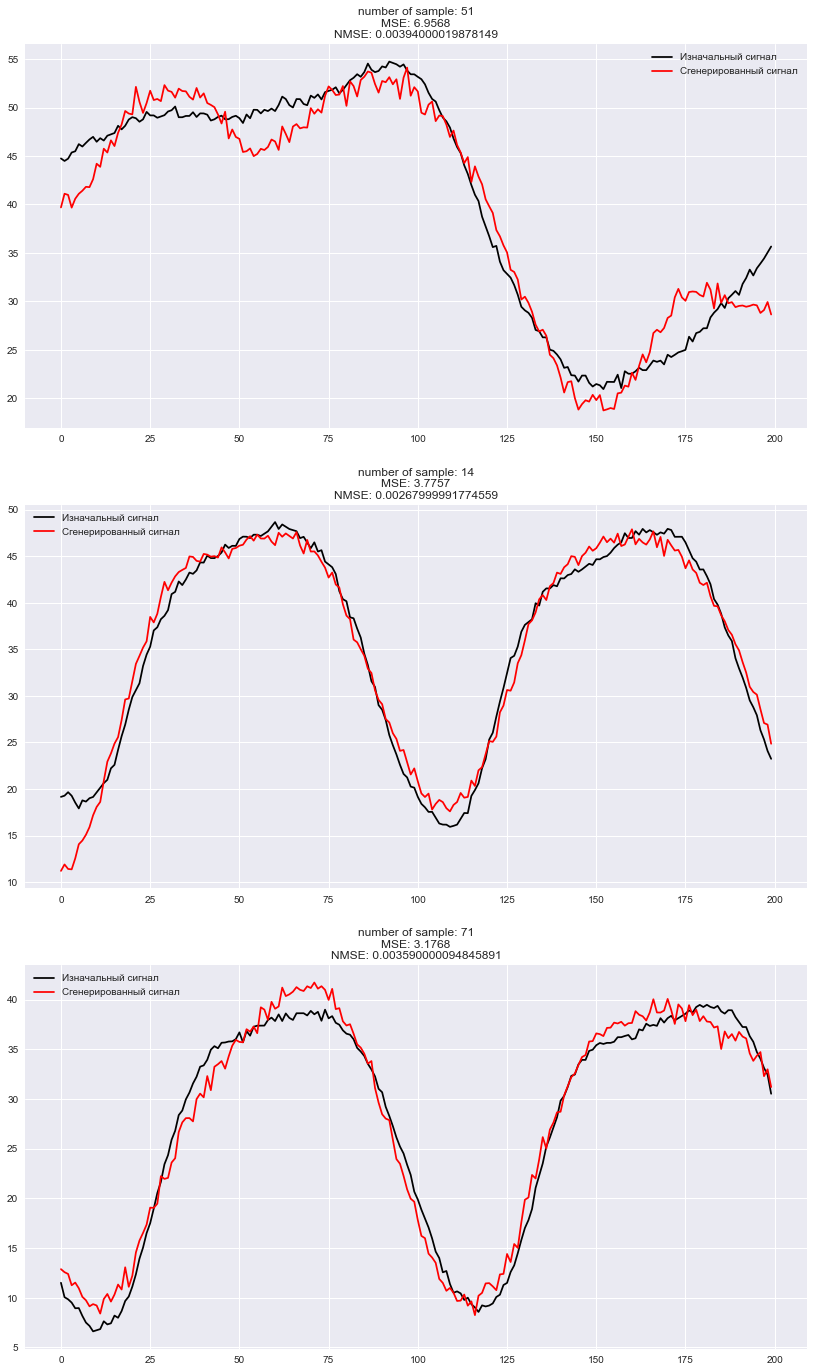

In [99]:
N = 3
tensor_check(net, X_val_tensor, N, x_mean, x_var, without_unnorm=False)

### Тесты на тестовой выборке

In [100]:
def get_noisy_signals(signals: np.ndarray, N: int, gamma: float = 0.2 , prob: float = 0.7) -> np.ndarray:
    '''
    N is supposed to be greater than 1
    '''
    noisy_signals = signals[np.random.choice(np.arange(len(signals)), size=N, replace=False)]
    for signal in noisy_signals:
        d = np.max(signal) - np.min(signal)
        probs = np.random.random(len(signal))
        noise = d*gamma*(2*np.random.random(len(signal))-1)
        add = noise* (probs < prob)
        signal += add
            
    return noisy_signals
   
def get_replaced_signals(signals: np.ndarray, N: int, part: list = [0.4, 0.6], func: object = lambda x: x) -> np.ndarray:
    '''
    N is supposed to be greater than 1
    part is intended for interval of signal which would be replaced (middle is default)
    func is function which should replace a part of a signal (currently undone)
    '''
    replaced_signals = signals[np.random.choice(np.arange(len(signals)), size=N, replace=False)]
    left = int(len(signals[0])*part[0])
    right = int(len(signals[0])*part[1])
    x_part = np.arange(right-left)
    for signal in replaced_signals:
        y_left, y_right = signal[left], signal[right-1]
        y_new = y_left + (y_right-y_left)/len(x_part)*x_part
        signal[left:right] = y_new
    
    return replaced_signals
    
    

**Зашумлённые сигналы из обучающей выборки**

*небольшой шум по всей длине сигнала*

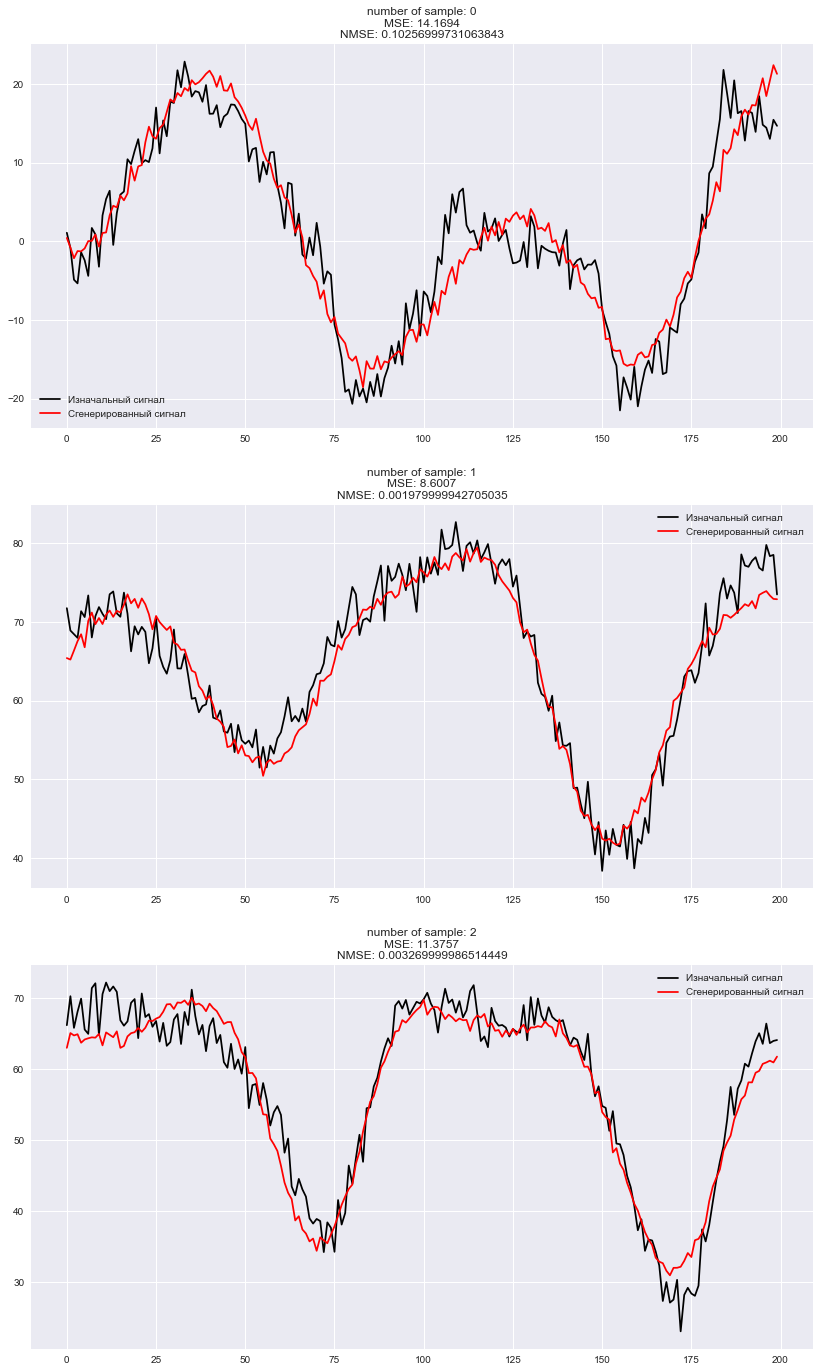

In [101]:
N = 3
X_train = X_train_tensor.detach().numpy()
noisy_signals = get_noisy_signals(X_train, N, gamma=0.1, prob=0.8)
tensor_check(net, torch.FloatTensor(noisy_signals), N, x_mean, x_var, without_unnorm=False, without_sampling=True)

*сильный шум в паре мест*

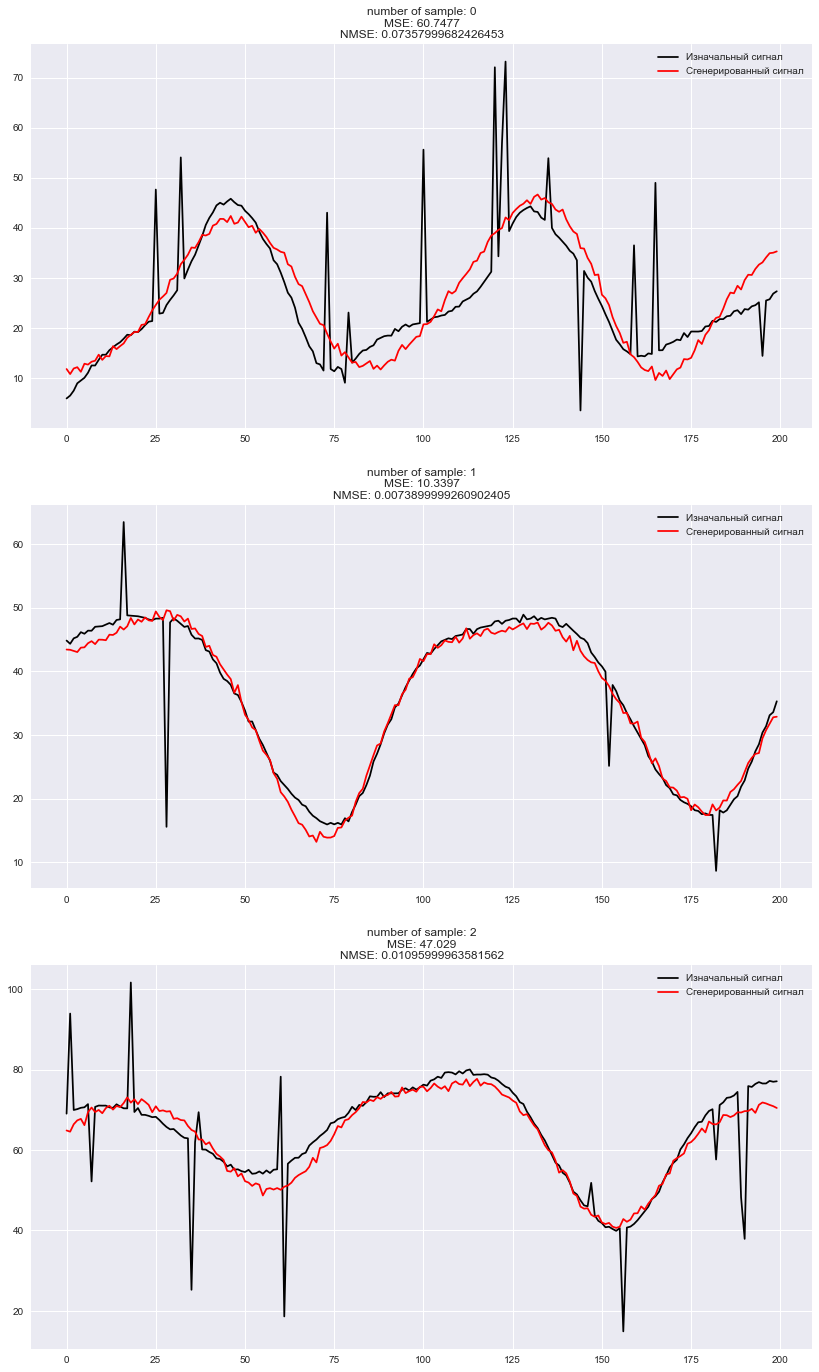

In [102]:
N = 3
X_train = X_train_tensor.detach().numpy()
noisy_signals = get_noisy_signals(X_train, N, gamma=1, prob=0.05)
tensor_check(net, torch.FloatTensor(noisy_signals), N, x_mean, x_var, without_unnorm=False, without_sampling=True)

**Сигналы из обучающей выборки с заменой части сигнала**

*В начале сигнала*

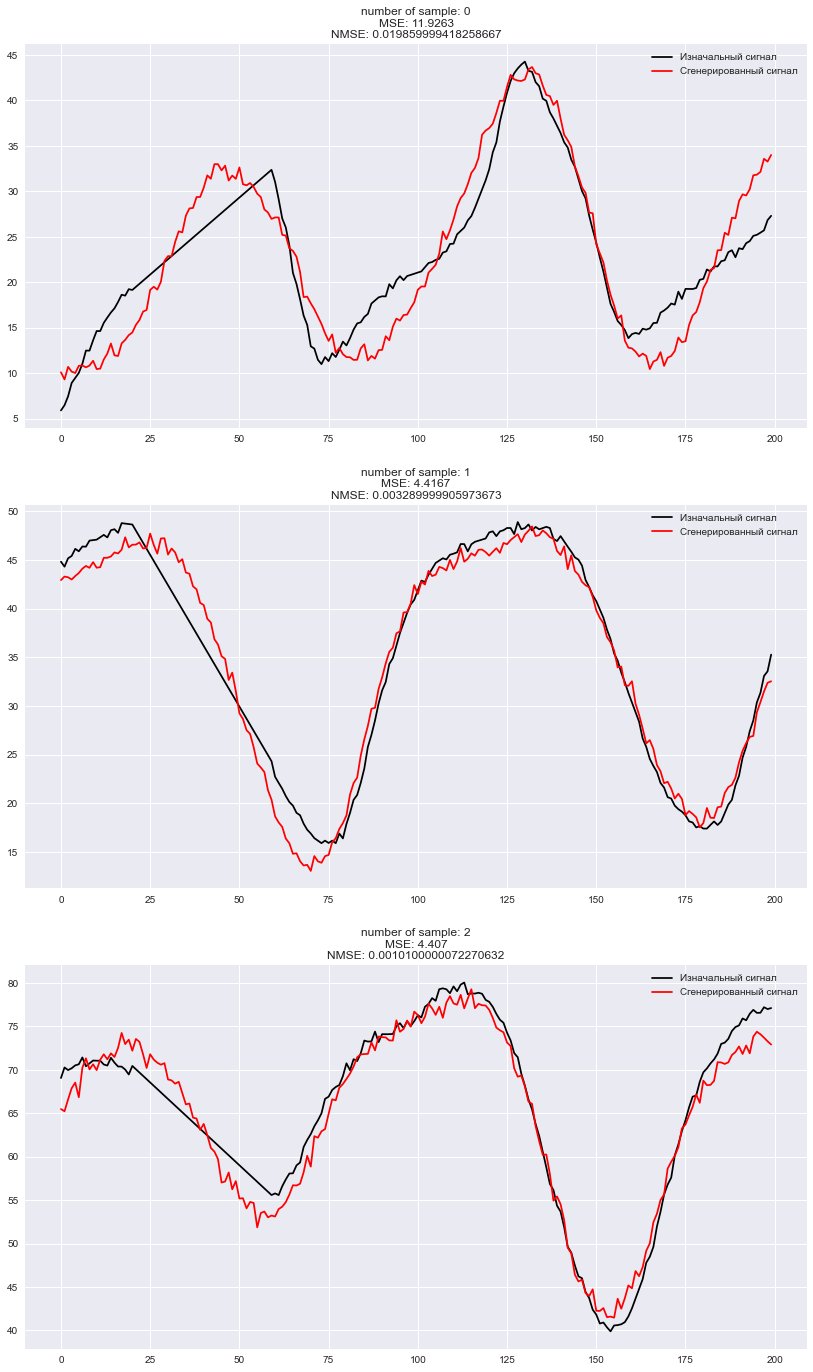

In [103]:
N = 3
X_train = X_train_tensor.detach().numpy()
replaced_start_signals = get_replaced_signals(X_train, N, part=[0.1,0.3])
tensor_check(net, torch.FloatTensor(replaced_start_signals), N, x_mean, x_var, without_unnorm=False, without_sampling=True)

*В середине сигнала*

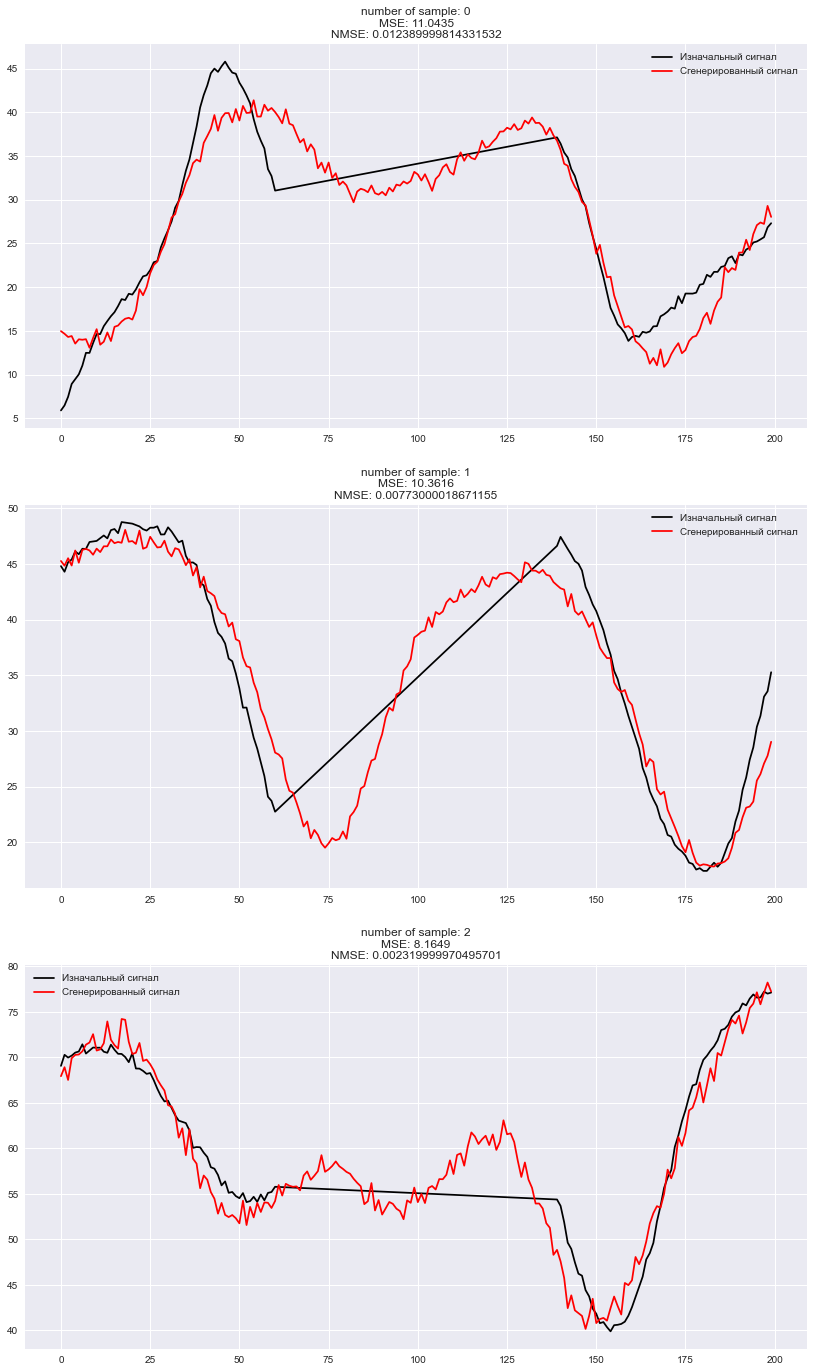

In [104]:
N = 3
X_train = X_train_tensor.detach().numpy()
replaced_middle_signals = get_replaced_signals(X_train, N, part=[0.3,0.7])
tensor_check(net, torch.FloatTensor(replaced_middle_signals), N, x_mean, x_var, without_unnorm=False, without_sampling=True)

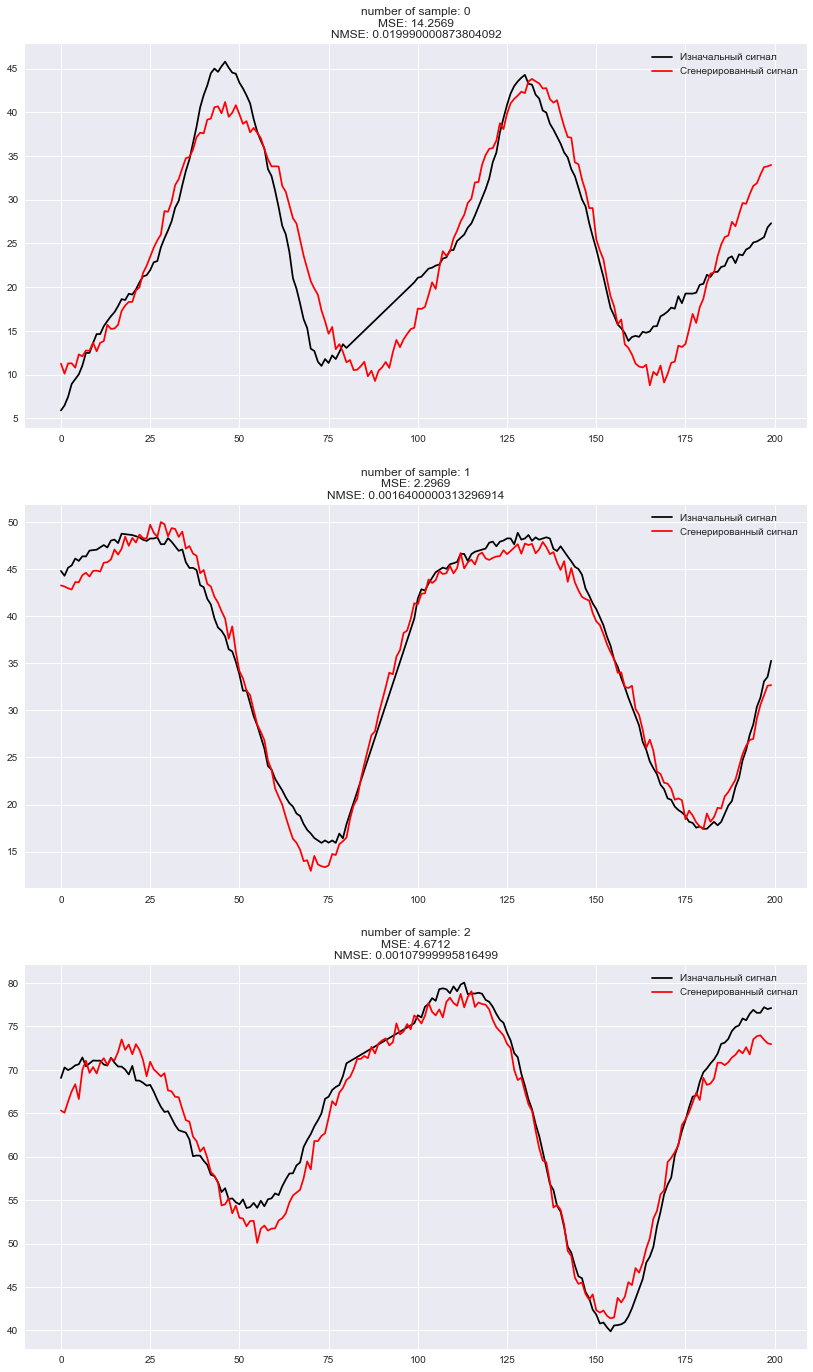

In [105]:
N = 3
X_train = X_train_tensor.detach().numpy()
replaced_middle_signals = get_replaced_signals(X_train, N, part=[0.4,0.5])
tensor_check(net, torch.FloatTensor(replaced_middle_signals), N, x_mean, x_var, without_unnorm=False, without_sampling=True)

*В конце сигнала*

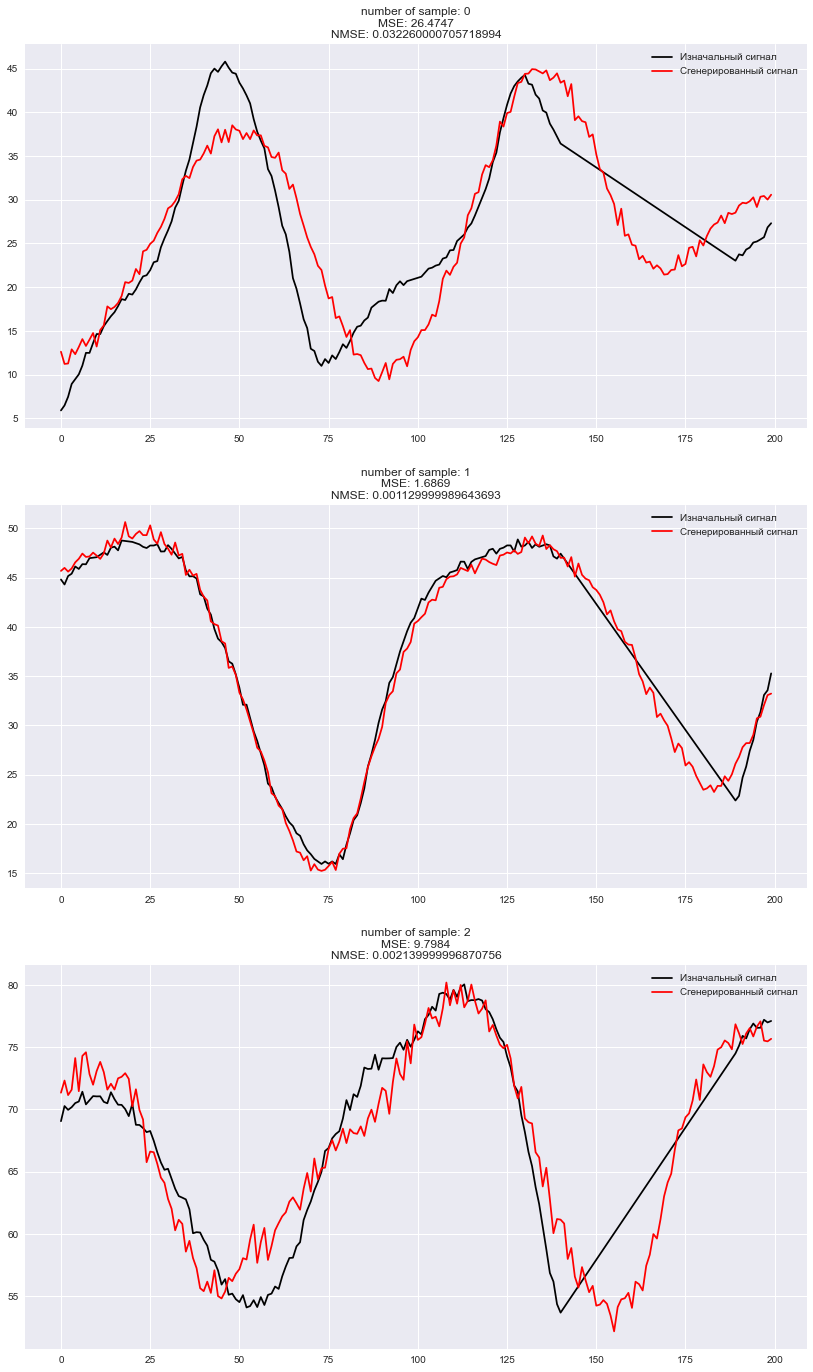

In [106]:
N = 3
X_train = X_train_tensor.detach().numpy()
replaced_end_signals = get_replaced_signals(X_train, N, part=[0.7,0.95])
tensor_check(net, torch.FloatTensor(replaced_end_signals), N, x_mean, x_var, without_unnorm=False, without_sampling=True)

**Сигналы из другой группы**

In [109]:
another_group_num = np.random.randint(NUMBER_OF_GROUPS)
another_group = signal_groups[another_group_num]
another_group_num

3

In [110]:
an_X_norm = np.array(another_group, dtype=np.float64)
an_X_norm -= x_mean
if x_var:
    an_X_norm /= x_var
else:
    an_X_norm *= 0

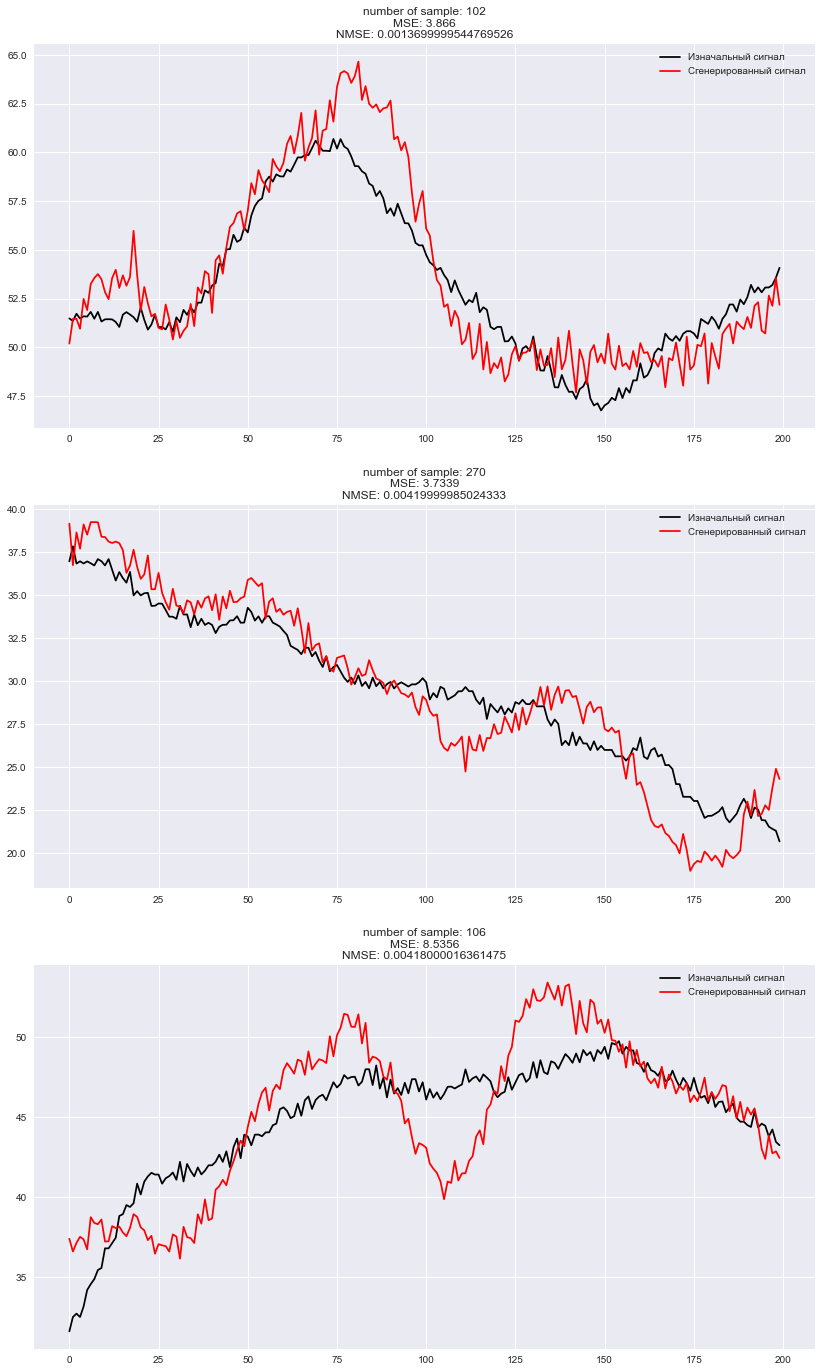

In [111]:
N = 3
tensor_check(net, torch.FloatTensor(an_X_norm), N, x_mean, x_var, without_unnorm=False)

In [112]:
def get_tensor_results(model, tensor, mean, var):
    out = model(tensor).detach().numpy()
    out = out*var + mean
    origin = tensor.detach().numpy()
    origin = origin*var + mean
    
    mse = MSE(origin, out)
    nmse = NMSE(origin, out)
    m = np.mean(out, axis=(0,1))
    v = np.mean(np.var(out, axis=1))
    return m, v, mse, nmse
    

In [113]:
get_tensor_results(net, X_train_tensor, x_mean, x_var)

(27.949657, 117.11184, 7.3570647, 0.005802592)

### Таблички

In [117]:
def get_table(model, mean, var, train, val, origin) -> pd.DataFrame:
    idxs = pd.Index(["train", "val", "little_noise", "peak_noise", "changed"]) # without 'basic' check for now
    little_noise = get_noisy_signals(origin, len(origin), gamma=0.3, prob=0.7)
    peak_noise = get_noisy_signals(origin, len(origin), gamma=1, prob=0.2)
    changed_middle = get_replaced_signals(origin, len(origin), part=[0.35,0.55])
    tensors = [train, val, torch.FloatTensor(little_noise), torch.FloatTensor(peak_noise), torch.FloatTensor(changed_middle)]
    data = [get_tensor_results(model, el, mean, var) for el in tensors]
    columns = ['mean', 'variance', 'MSE', "NMSE"]
    df = pd.DataFrame(data=data, index=idxs, columns=columns)
    return df
    

In [118]:
get_table(net, x_mean, x_var, X_train_tensor, X_val_tensor, X_norm)

,mean,variance,MSE,NMSE
train,27.949657,117.111839,7.357065,0.005803
val,26.504108,112.537468,13.421227,0.009727
little_noise,27.650459,115.805092,38.682892,0.029326
peak_noise,27.769089,116.401611,102.147369,0.073613
changed,27.643198,109.783615,9.586061,0.007468
